# 🔬 Analyse Antares — Scénarios EPR
**TP Antares 2040 — Opportunités de décarbonation par les EPR**

Ce notebook charge automatiquement tous les fichiers `.xlsx` Antares du dossier courant,  
extrait les indicateurs clés et génère des graphiques comparatifs.

---
### 📁 Comment utiliser ce notebook
1. Placer ce notebook dans le **même dossier** que vos fichiers Excel Antares
2. Nommer les fichiers avec le nombre d'EPR dans le nom (ex: `14_reacteurs.xlsx`, `12_reacteurs.xlsx`...)
3. Renseigner le dictionnaire `NOMS_SCENARIOS` si besoin
4. Exécuter toutes les cellules (`Run All`)

## ⚙️ 0. Configuration & imports

In [13]:
import pandas as pd
import openpyxl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Style graphiques
plt.rcParams.update({
    'figure.facecolor': 'white',
    'axes.facecolor': '#F8F9FA',
    'axes.grid': True,
    'grid.alpha': 0.4,
    'font.family': 'sans-serif',
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.titlesize': 13,
    'axes.labelsize': 11,
})

# ============================================================
# CONFIGURATION — à modifier selon vos fichiers
# ============================================================
DOSSIER_EXCEL = "."   # dossier des fichiers xlsx (. = dossier courant)

# Noms personnalisés (optionnel) — clé = nom de fichier, valeur = nom affiché
NOMS_SCENARIOS = {
    "16_reacteurs.xlsx": "16 EPR",
    "14_reaccteurs.xlsx": "14 EPR (référence)",
    "12_reacteurs.xlsx":  "12 EPR",
    "10_reacteurs.xlsx":  "10 EPR",
    "8_reacteurs.xlsx":   "8 EPR",
}
print('✅ Configuration OK')

✅ Configuration OK


## 📥 1. Chargement des données

In [14]:
# Indicateurs à extraire
INDICATEURS = [
    ("('LOLD', 'Hours', 'EXP')",         "sum",  "LOLD",                        "h/an"),
    ("('LOLP', '%', 'values')",           "mean", "LOLP",                        "%"),
    ("('UNSP. ENRG', 'MWh', 'EXP')",     "sum",  "Energie non servie",          "MWh"),
    ("('SPIL. ENRG', 'MWh', 'EXP')",     "sum",  "Spillage EnR",                "MWh"),
    ("('CO2 EMIS.', 'Tons', 'EXP')",     "sum",  "Emissions CO2",               "T"),
    ("('OP. COST', 'Euro', 'EXP')",       "sum",  "OPEX",                        "€"),
    ("('MRG. PRICE', 'Euro', 'EXP')",    "mean", "Prix marginal moyen",         "€/MWh"),
    ("('MRG. PRICE', 'Euro', 'EXP')",    "max",  "Prix marginal max",           "€/MWh"),
    ("('MRG. PRICE', 'Euro', 'EXP')",    "median","Prix marginal médian",       "€/MWh"),
    ("('BALANCE', 'MWh', 'EXP')",        "sum",  "Balance nette (export+)",     "MWh"),
    ("('LOAD', 'MWh', 'EXP')",           "sum",  "Consommation",                "MWh"),
    ("('NUCLEAR', 'MWh', 'EXP')",        "sum",  "Production nucléaire",        "MWh"),
    ("('GAS', 'MWh', 'EXP')",            "sum",  "Production gaz",              "MWh"),
    ("('COAL', 'MWh', 'EXP')",           "sum",  "Production charbon",          "MWh"),
    ("('LIGNITE', 'MWh', 'EXP')",        "sum",  "Production lignite",          "MWh"),
    ("('OIL', 'MWh', 'EXP')",            "sum",  "Production fioul",            "MWh"),
    ("('WIND OFFSHORE', 'MWh', 'EXP')",  "sum",  "Eolien offshore",             "MWh"),
    ("('WIND ONSHORE', 'MWh', 'EXP')",   "sum",  "Eolien onshore",              "MWh"),
    ("('SOLAR PV', 'MWh', 'EXP')",       "sum",  "Solaire PV",                  "MWh"),
    ("('SOLAR ROOFT', 'MWh', 'EXP')",    "sum",  "Solaire toiture",             "MWh"),
    ("('H. ROR', 'MWh', 'EXP')",         "sum",  "Hydraulique fil d'eau",       "MWh"),
    ("('H. STOR', 'MWh', 'EXP')",        "sum",  "Hydraulique stockage",        "MWh"),
]

def lire_excel(filepath):
    """Lit un fichier Excel Antares, retourne (df_annuel, df_horaire)."""
    wb = openpyxl.load_workbook(filepath)
    ws = wb.active
    headers = [cell.value for cell in ws[1]]
    data = list(ws.iter_rows(min_row=2, values_only=True))
    df = pd.DataFrame(data, columns=headers)
    df['datetime'] = pd.to_datetime(df[None], errors='coerce')
    df = df.dropna(subset=['datetime'])
    
    # Extraction indicateurs annuels
    result = {}
    for col, agg, label, unit in INDICATEURS:
        key = f"{label} [{unit}]"
        if col in df.columns:
            series = pd.to_numeric(df[col], errors='coerce')
            if agg == "sum":    result[key] = series.sum()
            elif agg == "mean": result[key] = series.mean()
            elif agg == "max":  result[key] = series.max()
            elif agg == "median": result[key] = series.median()
        else:
            result[key] = np.nan
    
    # Indicateurs dérivés
    prod_totale = sum(result.get(f"{l} [MWh]", 0) or 0 for l in [
        "Production nucléaire", "Production gaz", "Production charbon",
        "Production lignite", "Production fioul",
        "Eolien offshore", "Eolien onshore", "Solaire PV", "Solaire toiture",
        "Hydraulique fil d'eau", "Hydraulique stockage"
    ])
    if prod_totale > 0:
        result["Part nucléaire [%]"] = result.get("Production nucléaire [MWh]", 0) / prod_totale * 100
        fossile = sum(result.get(f"{l} [MWh]", 0) or 0 for l in
                      ["Production gaz", "Production charbon", "Production lignite", "Production fioul"])
        result["Part fossile [%]"] = fossile / prod_totale * 100
        result["Intensité CO2 [gCO2/kWh]"] = (result.get("Emissions CO2 [T]", 0) or 0) * 1000 / prod_totale
    
    return result, df

# Chargement
dossier = Path(DOSSIER_EXCEL)
import re
def extraire_nombre(filepath):
    m = re.search(r'(\d+)', filepath.stem)
    return int(m.group(1)) if m else 9999
FICHIER_SORTIE = 'comparaison_scenarios_EPR.xlsx'
fichiers = sorted(
    [f for f in dossier.glob("*.xlsx") if f.name != FICHIER_SORTIE],
    key=extraire_nombre
)
print(f"📂 {len(fichiers)} fichier(s) trouvé(s) :")
for f in fichiers:
    print(f"   • {f.name}")

resultats_annuels = {}
resultats_horaires = {}
for f in fichiers:
    nom = NOMS_SCENARIOS.get(f.name, f.stem.replace('_', ' ').replace('reaccteurs', 'EPR').replace('reacteurs', 'EPR'))
    print(f"   ⏳ Lecture {f.name}...", end=" ")
    r, df_h = lire_excel(f)
    resultats_annuels[nom] = r
    resultats_horaires[nom] = df_h
    print("✅")

df_res = pd.DataFrame(resultats_annuels).T
print(f"\n✅ Données chargées pour {len(df_res)} scénario(s)")

📂 5 fichier(s) trouvé(s) :
   • 08 reacteurs.xlsx
   • 10 reacteurs.xlsx
   • 12 reacteurs.xlsx
   • 14 reaccteurs.xlsx
   • 16 reacteurs.xlsx
   ⏳ Lecture 08 reacteurs.xlsx... ✅
   ⏳ Lecture 10 reacteurs.xlsx... ✅
   ⏳ Lecture 12 reacteurs.xlsx... ✅
   ⏳ Lecture 14 reaccteurs.xlsx... ✅
   ⏳ Lecture 16 reacteurs.xlsx... ✅

✅ Données chargées pour 5 scénario(s)


## 📊 2. Tableau de synthèse

In [15]:
cols_synthese = [
    "LOLD [h/an]", "Energie non servie [MWh]", "Spillage EnR [MWh]",
    "Emissions CO2 [T]", "Intensité CO2 [gCO2/kWh]",
    "OPEX [€]", "Prix marginal moyen [€/MWh]", "Prix marginal médian [€/MWh]",
    "Balance nette (export+) [MWh]",
    "Production nucléaire [MWh]", "Production gaz [MWh]",
    "Part nucléaire [%]", "Part fossile [%]"
]
cols_dispo = [c for c in cols_synthese if c in df_res.columns]

def fmt_val(val, col):
    if pd.isna(val): return "—"
    if "€" in col and "MWh" not in col: return f"{val/1e9:.2f} G€"
    if "MWh" in col and val > 1e9: return f"{val/1e9:.2f} TWh"
    if "MWh" in col and val > 1e6: return f"{val/1e6:.1f} TWh"
    if "MWh" in col and val > 1e3: return f"{val/1e3:.0f} GWh"
    if "%" in col: return f"{val:.1f}%"
    if "gCO2" in col: return f"{val:.1f}"
    return f"{val:,.1f}"

df_display = df_res[cols_dispo].copy()
for col in df_display.columns:
    df_display[col] = df_display[col].apply(lambda v: fmt_val(v, col))

display(df_display.T.style.set_properties(**{
    'text-align': 'right', 'font-size': '12px'
}).set_table_styles([{
    'selector': 'th', 
    'props': [('background-color', '#2C3E50'), ('color', 'white'), 
              ('font-weight', 'bold'), ('text-align', 'center')]
}]))

,08 EPR,10 EPR,12 EPR,14 EPR,16 EPR
LOLD [h/an],13.2,8.6,5.0,3.2,1.6
Energie non servie [MWh],106 GWh,61 GWh,34 GWh,22 GWh,9 GWh
Spillage EnR [MWh],1.7 TWh,1.9 TWh,2.2 TWh,2.4 TWh,2.7 TWh
Emissions CO2 [T],"7,196,649.0","6,844,307.0","6,479,600.0","6,103,850.0","5,687,939.0"
Intensité CO2 [gCO2/kWh],10.1,9.4,8.7,8.1,7.4
OPEX [€],12.67 G€,12.99 G€,13.31 G€,13.58 G€,13.85 G€
Prix marginal moyen [€/MWh],118.3,108.3,100.6,94.3,87.7
Prix marginal médian [€/MWh],100.6,96.6,92.8,88.9,84.4
Balance nette (export+) [MWh],109.3 TWh,125.7 TWh,141.8 TWh,156.4 TWh,171.7 TWh
Production nucléaire [MWh],337.8 TWh,356.1 TWh,374.3 TWh,391.0 TWh,408.5 TWh


## 📈 3. Graphiques comparatifs
### 3.1 Sécurité d'approvisionnement — LOLD & énergie non servie

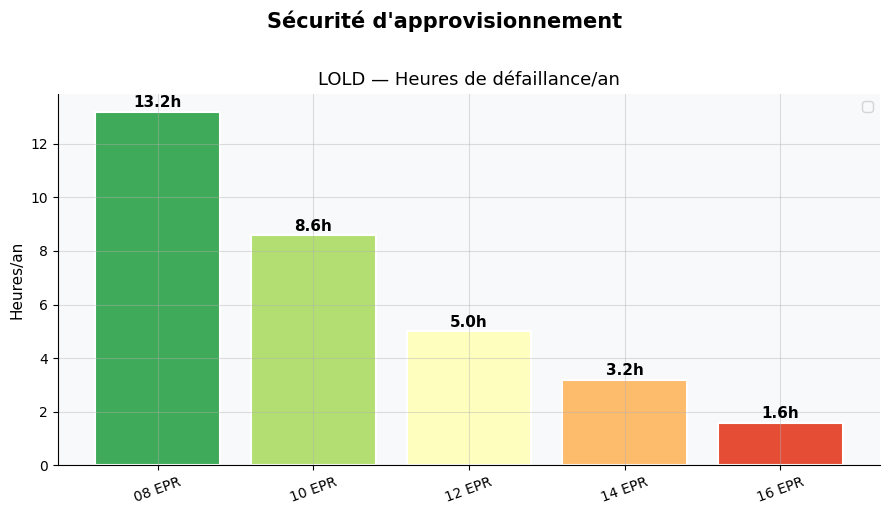

In [ ]:
scenarios = list(df_res.index)
colors_scenarios = plt.cm.RdYlGn(np.linspace(0.85, 0.15, len(scenarios)))

fig, ax = plt.subplots( figsize=(9, 5))
fig.suptitle('Sécurité d\'approvisionnement', fontsize=15, fontweight='bold', y=1.02)

# LOLD
vals = df_res["LOLD [h/an]"].values
bars = ax.bar(scenarios, vals, color=colors_scenarios, edgecolor='white', linewidth=1.5)
ax.axhline(3, color='red', linestyle='--', linewidth=1.5, label='Seuil 3h/an (France)')
ax.set_title('LOLD — Heures de défaillance/an')
ax.set_ylabel('Heures/an')
ax.legend()
for bar, v in zip(bars, vals):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
            f'{v:.1f}h', ha='center', va='bottom', fontweight='bold', fontsize=11)
ax.tick_params(axis='x', rotation=20)

# Energie non servie
# ax = axes[1]
# vals_ens = df_res["Energie non servie [MWh]"].values / 1e3
# bars2 = ax.bar(scenarios, vals_ens, color=colors_scenarios, edgecolor='white', linewidth=1.5)
# ax.set_title('Energie Non Servie (ENS)')
# ax.set_ylabel('GWh/an')
# for bar, v in zip(bars2, vals_ens):
#     ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(vals_ens)*0.01,
#             f'{v:.1f}', ha='center', va='bottom', fontweight='bold', fontsize=11)
# ax.tick_params(axis='x', rotation=20)

plt.tight_layout()
plt.savefig('fig_securite.png', dpi=300, bbox_inches='tight')
plt.show()

### 3.2 Mix de production par scénario (graphique empilé)

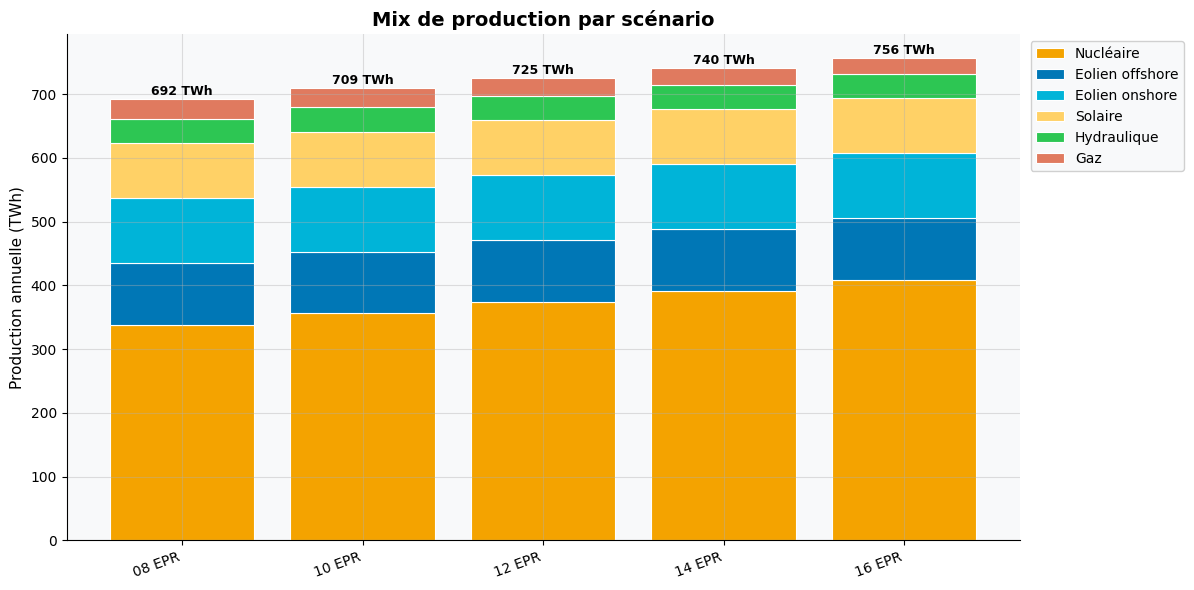

In [ ]:
# sources_mix = {
#     'Nucléaire':          ('Production nucléaire [MWh]',    '#F4A300'),
#     'Eolien offshore':    ('Eolien offshore [MWh]',         '#0077B6'),
#     'Eolien onshore':     ('Eolien onshore [MWh]',          '#00B4D8'),
#     'Solaire':            ('Solaire PV [MWh]',              '#FFD166'),
#     'Hydraulique':        ("Hydraulique fil d'eau [MWh]",   '#2DC653'),
#     'Gaz':                ('Production gaz [MWh]',          '#E07A5F'),
#     'Charbon/Lignite':    ('Production charbon [MWh]',      '#6D6875'),
#     'Fioul':              ('Production fioul [MWh]',        '#3D405B'),
# }

# fig, ax = plt.subplots(figsize=(12, 6))
# x = np.arange(len(scenarios))
# bottom = np.zeros(len(scenarios))

# for label, (col, color) in sources_mix.items():
#     if col in df_res.columns:
#         vals = df_res[col].fillna(0).values / 1e6  # en TWh
#         if vals.sum() > 0:
#             ax.bar(x, vals, bottom=bottom, label=label, color=color,
#                    edgecolor='white', linewidth=0.8)
#             bottom += vals

# ax.set_xticks(x)
# ax.set_xticklabels(scenarios, rotation=20, ha='right')
# ax.set_ylabel('Production annuelle (TWh)')
# ax.set_title('Mix de production par scénario', fontsize=14, fontweight='bold')
# ax.legend(loc='upper right', bbox_to_anchor=(1.18, 1), framealpha=0.9)

# # Valeur totale au-dessus de chaque barre
# for i, s in enumerate(scenarios):
#     ax.text(i, bottom[i] + 2, f'{bottom[i]:.0f} TWh',
#             ha='center', va='bottom', fontsize=9, fontweight='bold')

# plt.tight_layout()
# plt.savefig('fig_mix_production.png', dpi=150, bbox_inches='tight')
# plt.show()

### 3.3 Emissions CO2 & intensité carbone

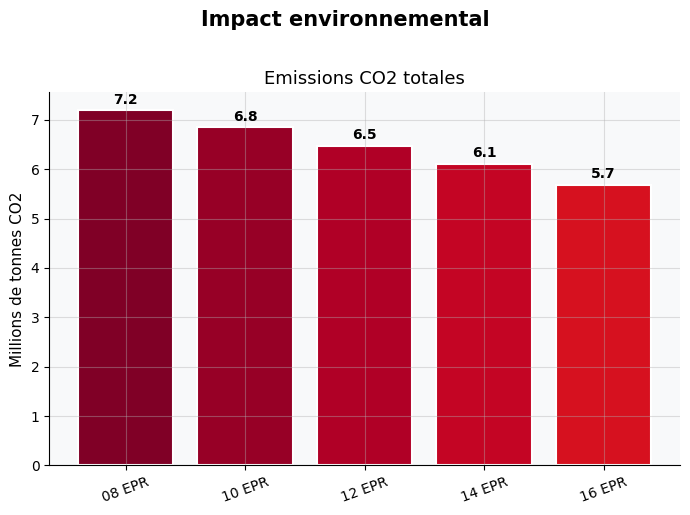

In [41]:
fig, ax = plt.subplots( figsize=(7, 5))
fig.suptitle('Impact environnemental', fontsize=15, fontweight='bold', y=1.02)

color_co2 = '#2D6A4F'

# Emissions CO2 totales
# ax = axes[0]
vals = df_res["Emissions CO2 [T]"].values / 1e6
bars = ax.bar(scenarios, vals, color=[plt.cm.YlOrRd(v/max(vals+0.001)) for v in vals],
              edgecolor='white', linewidth=1.5)
ax.set_title('Emissions CO2 totales')
ax.set_ylabel('Millions de tonnes CO2')
for bar, v in zip(bars, vals):
    ax.text(bar.get_x()+bar.get_width()/2, bar.get_height()+max(vals)*0.01,
            f'{v:.1f}', ha='center', va='bottom', fontweight='bold')
ax.tick_params(axis='x', rotation=20)

# Intensité CO2
# ax = axes[1]
# if "Intensité CO2 [gCO2/kWh]" in df_res.columns:
#     vals2 = df_res["Intensité CO2 [gCO2/kWh]"].values
#     bars2 = ax.bar(scenarios, vals2, color=[plt.cm.YlOrRd(v/max(vals2+0.001)) for v in vals2],
#                    edgecolor='white', linewidth=1.5)
#     ax.set_title('Intensité carbone du mix')
#     ax.set_ylabel('gCO2/kWh')
#     ax.legend()
#     for bar, v in zip(bars2, vals2):
#         ax.text(bar.get_x()+bar.get_width()/2, bar.get_height()+max(vals2)*0.01,
#                 f'{v:.1f}', ha='center', va='bottom', fontweight='bold')
#     ax.tick_params(axis='x', rotation=20)

plt.tight_layout()
plt.savefig('fig_co2.png', dpi=150, bbox_inches='tight')
plt.show()

### 3.4 Coûts opérationnels (OPEX) & prix marginal

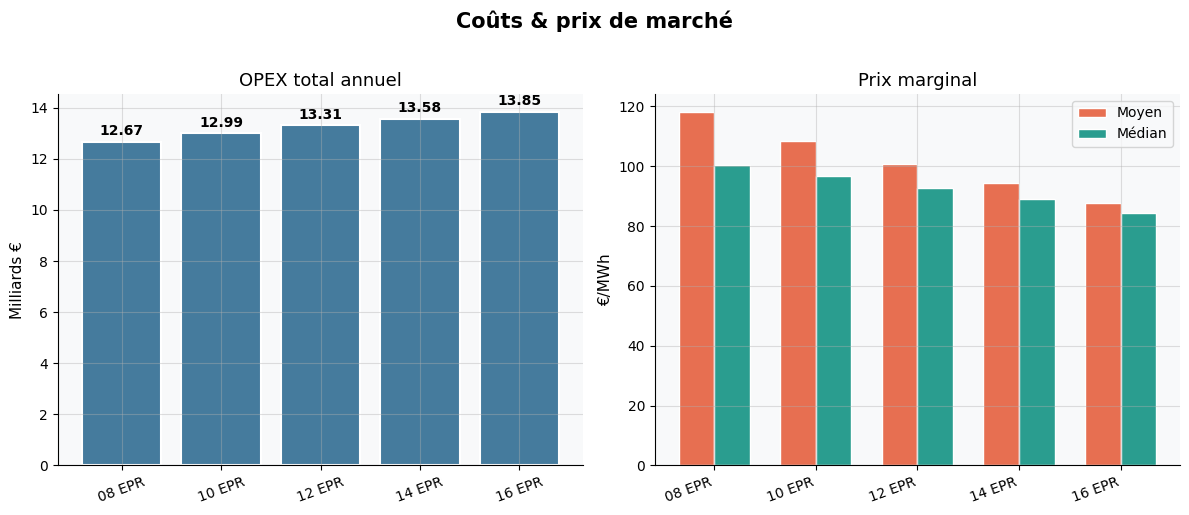

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Coûts & prix de marché', fontsize=15, fontweight='bold', y=1.02)

# OPEX
ax = axes[0]
vals = df_res["OPEX [€]"].values / 1e9
bars = ax.bar(scenarios, vals, color='#457B9D', edgecolor='white', linewidth=1.5)
ax.set_title('OPEX total annuel')
ax.set_ylabel('Milliards €')
for bar, v in zip(bars, vals):
    ax.text(bar.get_x()+bar.get_width()/2, bar.get_height()+max(vals)*0.01,
            f'{v:.2f}', ha='center', va='bottom', fontweight='bold')
ax.tick_params(axis='x', rotation=20)

# Prix marginal moyen vs médian
ax = axes[1]
w = 0.35
x = np.arange(len(scenarios))
moy = df_res["Prix marginal moyen [€/MWh]"].values
med = df_res["Prix marginal médian [€/MWh]"].values
ax.bar(x - w/2, moy, w, label='Moyen', color='#E76F51', edgecolor='white')
ax.bar(x + w/2, med, w, label='Médian', color='#2A9D8F', edgecolor='white')
ax.set_xticks(x)
ax.set_xticklabels(scenarios, rotation=20, ha='right')
ax.set_title('Prix marginal')
ax.set_ylabel('€/MWh')
ax.legend()

# Prix max (stress du système)
# ax = axes[2]
# vals_max = df_res["Prix marginal max [€/MWh]"].values
# bars = ax.bar(scenarios, vals_max, color='#C0392B', edgecolor='white', linewidth=1.5)
# ax.set_title('Prix marginal max (stress système)')
# ax.set_ylabel('€/MWh')
# ax.tick_params(axis='x', rotation=20)
# for bar, v in zip(bars, vals_max):
#     ax.text(bar.get_x()+bar.get_width()/2, bar.get_height()+max(vals_max)*0.01,
#             f'{v:.0f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.savefig('fig_couts.png', dpi=150, bbox_inches='tight')
plt.show()

### 3.5 Balance des échanges & Spillage EnR

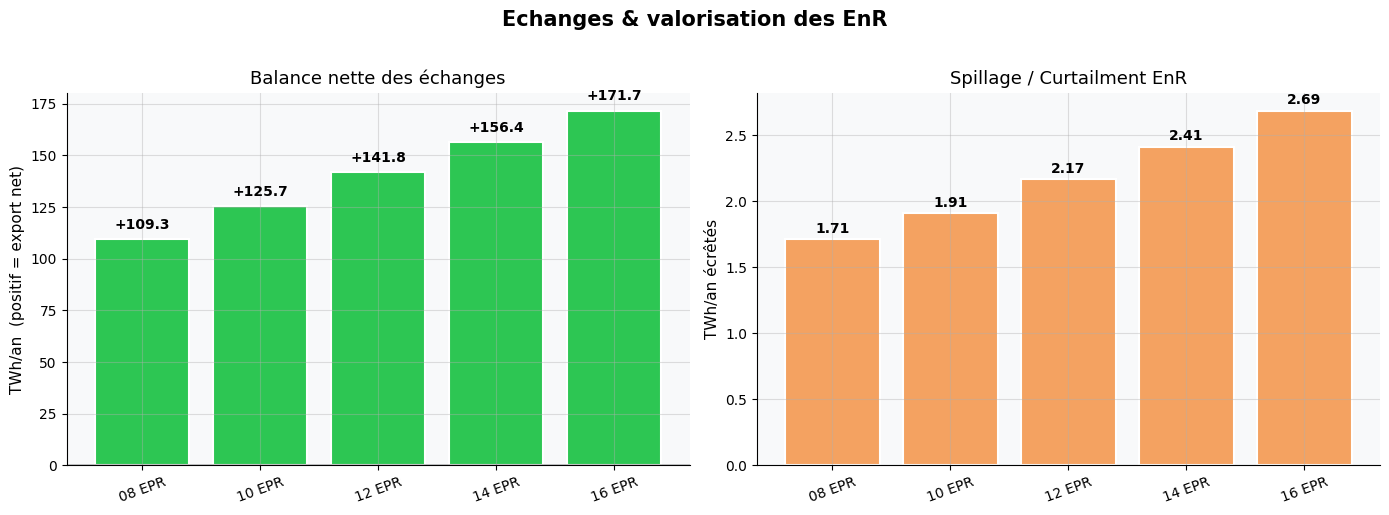

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Echanges & valorisation des EnR', fontsize=15, fontweight='bold', y=1.02)

# Balance
ax = axes[0]
vals = df_res["Balance nette (export+) [MWh]"].values / 1e6
colors_bal = ['#2DC653' if v >= 0 else '#E63946' for v in vals]
bars = ax.bar(scenarios, vals, color=colors_bal, edgecolor='white', linewidth=1.5)
ax.axhline(0, color='black', linewidth=1)
ax.set_title('Balance nette des échanges')
ax.set_ylabel('TWh/an  (positif = export net)')
for bar, v in zip(bars, vals):
    offset = max(abs(vals))*0.02
    va = 'bottom' if v >= 0 else 'top'
    y = v + offset if v >= 0 else v - offset
    ax.text(bar.get_x()+bar.get_width()/2, y,
            f'{v:+.1f}', ha='center', va=va, fontweight='bold')
ax.tick_params(axis='x', rotation=20)

# Spillage
ax = axes[1]
vals_sp = df_res["Spillage EnR [MWh]"].values / 1e6
bars2 = ax.bar(scenarios, vals_sp, color='#F4A261', edgecolor='white', linewidth=1.5)
ax.set_title('Spillage / Curtailment EnR')
ax.set_ylabel('TWh/an écrêtés')
for bar, v in zip(bars2, vals_sp):
    ax.text(bar.get_x()+bar.get_width()/2, bar.get_height()+max(vals_sp)*0.01,
            f'{v:.2f}', ha='center', va='bottom', fontweight='bold')
ax.tick_params(axis='x', rotation=20)

plt.tight_layout()
plt.savefig('fig_echanges.png', dpi=150, bbox_inches='tight')
plt.show()

### 3.6 Distribution horaire du prix marginal (courbe de durée)

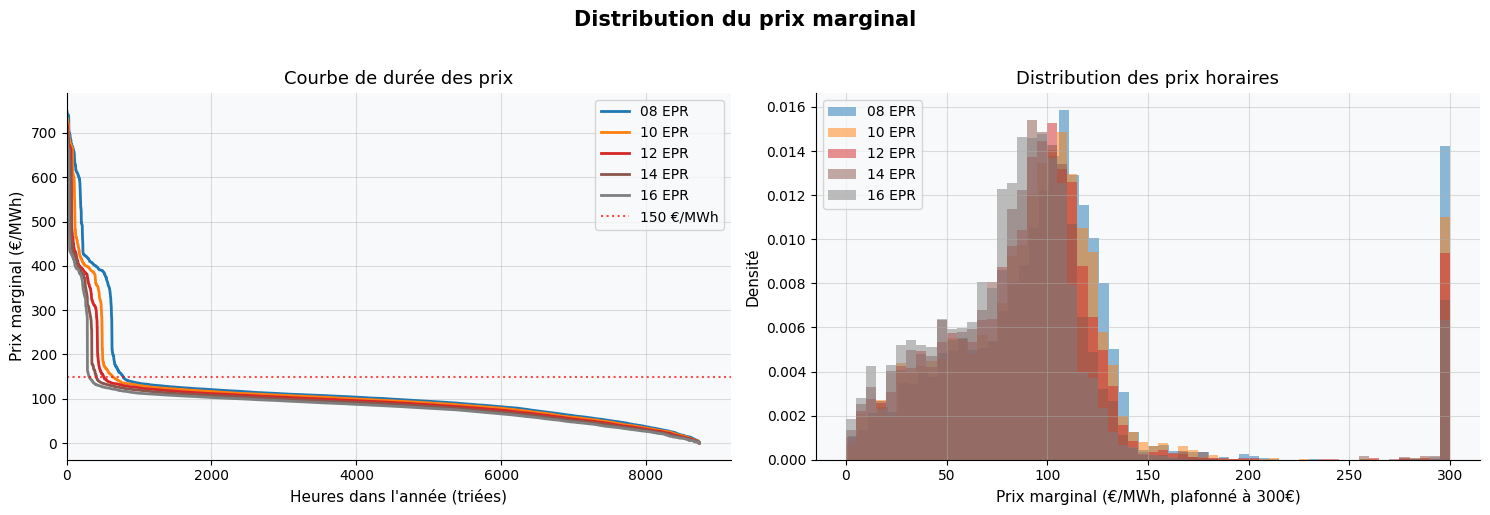

In [ ]:
# mrg_col = "('MRG. PRICE', 'Euro', 'EXP')"

# fig, axes = plt.subplots(1, 2, figsize=(15, 5))
# fig.suptitle('Distribution du prix marginal', fontsize=15, fontweight='bold', y=1.02)

# colors_sc = plt.cm.tab10(np.linspace(0, 0.7, len(scenarios)))

# for i, (scenario, df_h) in enumerate(resultats_horaires.items()):
#     if mrg_col not in df_h.columns:
#         continue
#     prices = pd.to_numeric(df_h[mrg_col], errors='coerce').dropna().sort_values(ascending=False)
    
#     # Courbe de durée
#     axes[0].plot(np.arange(len(prices)), prices.values, 
#                  label=scenario, color=colors_sc[i], linewidth=2)
    
#     # Histogramme (distribution)
#     axes[1].hist(prices.clip(upper=300), bins=60, alpha=0.5, 
#                  label=scenario, color=colors_sc[i], density=True)

# axes[0].set_xlabel('Heures dans l\'année (triées)')
# axes[0].set_ylabel('Prix marginal (€/MWh)')
# axes[0].set_title('Courbe de durée des prix')
# axes[0].set_xlim(0)
# axes[0].axhline(150, color='red', linestyle=':', alpha=0.7, label='150 €/MWh')
# axes[0].legend()

# axes[1].set_xlabel('Prix marginal (€/MWh, plafonné à 300€)')
# axes[1].set_ylabel('Densité')
# axes[1].set_title('Distribution des prix horaires')
# axes[1].legend()

# plt.tight_layout()
# plt.savefig('fig_prix_distribution.png', dpi=150, bbox_inches='tight')
# plt.show()

### 3.7 Profil saisonnier — Nucléaire & Gaz (MW moyen par mois)

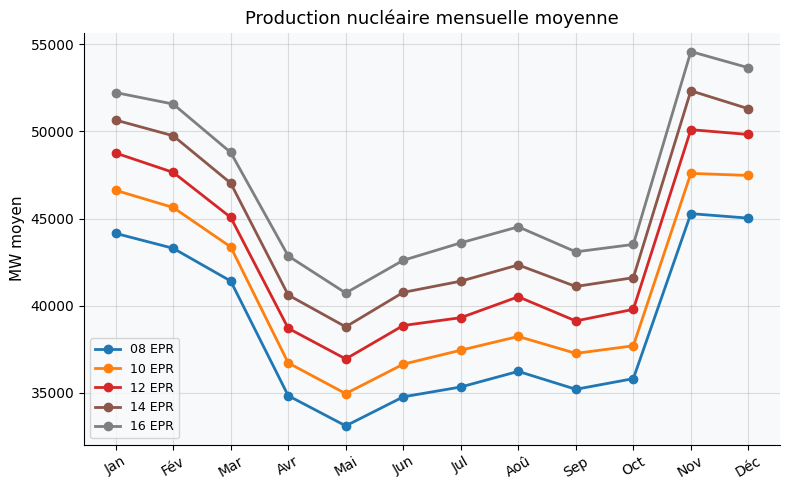

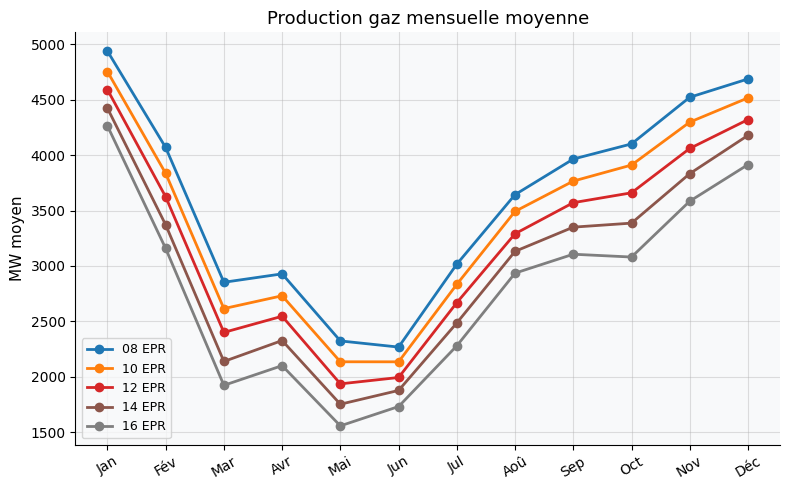

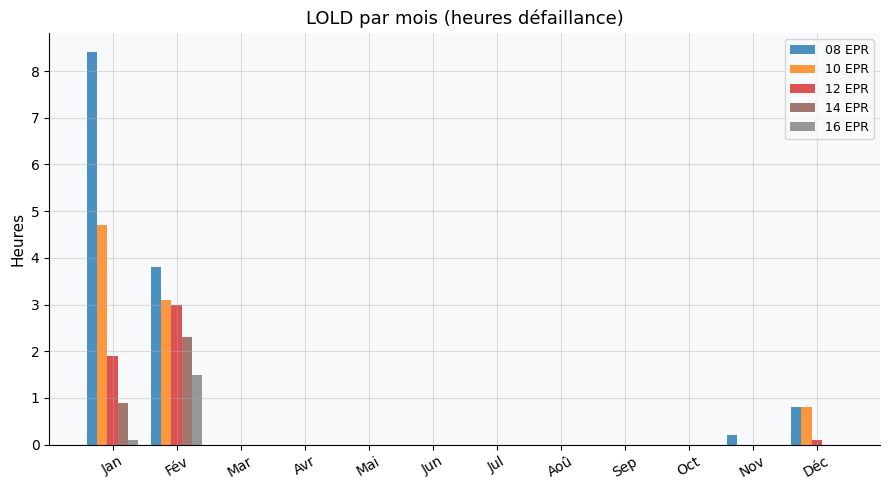

In [44]:
# ...existing code...
nuc_col  = "('NUCLEAR', 'MWh', 'EXP')"
gas_col  = "('GAS', 'MWh', 'EXP')"
lold_col = "('LOLD', 'Hours', 'EXP')"
mois_labels = ['Jan','Fév','Mar','Avr','Mai','Jun','Jul','Aoû','Sep','Oct','Nov','Déc']
colors_sc = plt.cm.tab10(np.linspace(0, 0.7, len(scenarios)))
x = np.arange(12)

# 1) Nucléaire
fig, ax = plt.subplots(figsize=(8, 5))
for i, (scenario, df_h) in enumerate(resultats_horaires.items()):
    month = pd.to_datetime(df_h['datetime']).dt.month
    if nuc_col in df_h.columns:
        nuc_monthly = pd.to_numeric(df_h[nuc_col], errors='coerce').groupby(month).mean().reindex(range(1, 13))
        ax.plot(x, nuc_monthly.values, 'o-', label=scenario, color=colors_sc[i], linewidth=2, markersize=6)

ax.set_xticks(x)
ax.set_xticklabels(mois_labels, rotation=30)
ax.set_title('Production nucléaire mensuelle moyenne')
ax.set_ylabel('MW moyen')
ax.legend(fontsize=9)
plt.tight_layout()
plt.savefig('fig_saisonnier_nucleaire.png', dpi=150, bbox_inches='tight')
plt.show()

# 2) Gaz
fig, ax = plt.subplots(figsize=(8, 5))
for i, (scenario, df_h) in enumerate(resultats_horaires.items()):
    month = pd.to_datetime(df_h['datetime']).dt.month
    if gas_col in df_h.columns:
        gas_monthly = pd.to_numeric(df_h[gas_col], errors='coerce').groupby(month).mean().reindex(range(1, 13))
        ax.plot(x, gas_monthly.values, 'o-', label=scenario, color=colors_sc[i], linewidth=2, markersize=6)

ax.set_xticks(x)
ax.set_xticklabels(mois_labels, rotation=30)
ax.set_title('Production gaz mensuelle moyenne')
ax.set_ylabel('MW moyen')
ax.legend(fontsize=9)
plt.tight_layout()
plt.savefig('fig_saisonnier_gaz.png', dpi=150, bbox_inches='tight')
plt.show()

# 3) LOLD
fig, ax = plt.subplots(figsize=(9, 5))
w = 0.8 / max(len(scenarios), 1)
for i, (scenario, df_h) in enumerate(resultats_horaires.items()):
    month = pd.to_datetime(df_h['datetime']).dt.month
    if lold_col in df_h.columns:
        lold_monthly = pd.to_numeric(df_h[lold_col], errors='coerce').groupby(month).sum().reindex(range(1, 13), fill_value=0)
        offset = (i - len(scenarios) / 2 + 0.5) * w
        ax.bar(x + offset, lold_monthly.values, width=w, label=scenario, color=colors_sc[i], alpha=0.8)

ax.set_xticks(x)
ax.set_xticklabels(mois_labels, rotation=30)
ax.set_title('LOLD par mois (heures défaillance)')
ax.set_ylabel('Heures')
ax.legend(fontsize=9)
plt.tight_layout()
plt.savefig('fig_saisonnier_lold.png', dpi=150, bbox_inches='tight')
plt.show()
# ...existing code...

### 3.8 Radar — Vue globale multi-critères

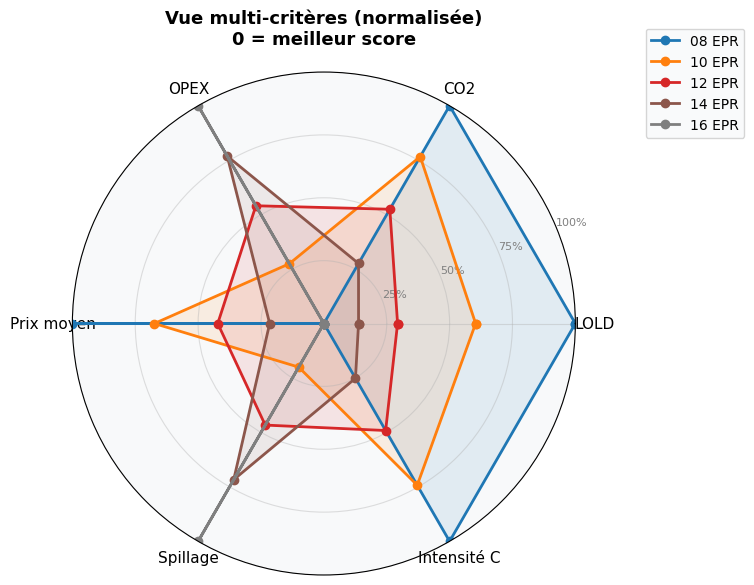

In [ ]:
# # Normalisation pour radar (0 = meilleur, 1 = pire)
# radar_metrics = {
#     'LOLD':         ('LOLD [h/an]', True),     # True = plus haut = pire
#     'CO2':          ('Emissions CO2 [T]', True),
#     'OPEX':         ('OPEX [€]', True),
#     'Prix moyen':   ('Prix marginal moyen [€/MWh]', True),
#     'Spillage':     ('Spillage EnR [MWh]', True),
#     'Intensité C':  ('Intensité CO2 [gCO2/kWh]', True),
# }

# # Vérification colonnes disponibles
# radar_metrics = {k: v for k, v in radar_metrics.items() if v[0] in df_res.columns}
# labels_radar = list(radar_metrics.keys())
# N = len(labels_radar)

# if N >= 3:
#     angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist()
#     angles += angles[:1]

#     fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
#     ax.set_title('Vue multi-critères (normalisée)\n0 = meilleur score', 
#                  fontsize=13, fontweight='bold', pad=20)

#     colors_sc = plt.cm.tab10(np.linspace(0, 0.7, len(scenarios)))

#     for i, scenario in enumerate(scenarios):
#         vals_norm = []
#         for metric, (col, higher_worse) in radar_metrics.items():
#             col_vals = df_res[col].values.astype(float)
#             mn, mx = np.nanmin(col_vals), np.nanmax(col_vals)
#             v = df_res.loc[scenario, col]
#             if mx > mn:
#                 norm = (v - mn) / (mx - mn)
#             else:
#                 norm = 0
#             vals_norm.append(norm if higher_worse else 1 - norm)
        
#         vals_norm += vals_norm[:1]
#         ax.plot(angles, vals_norm, 'o-', color=colors_sc[i], linewidth=2, label=scenario)
#         ax.fill(angles, vals_norm, alpha=0.1, color=colors_sc[i])

#     ax.set_xticks(angles[:-1])
#     ax.set_xticklabels(labels_radar, size=11)
#     ax.set_ylim(0, 1)
#     ax.set_yticks([0.25, 0.5, 0.75, 1.0])
#     ax.set_yticklabels(['25%', '50%', '75%', '100%'], size=8, color='grey')
#     ax.legend(loc='upper right', bbox_to_anchor=(1.35, 1.1))

#     plt.tight_layout()
#     plt.savefig('fig_radar.png', dpi=150, bbox_inches='tight')
#     plt.show()
# else:
#     print('⚠️ Pas assez de métriques disponibles pour le radar.')

### 3.9 Facteur de charge nucléaire — évolution & modulation
> **Lecture** : plus le FC est bas et variable, plus le nucléaire est modulé → risque de perte de rentabilité.
> La capacité nucléaire totale est estimée à partir du **max horaire** de production (≈ capacité installée).

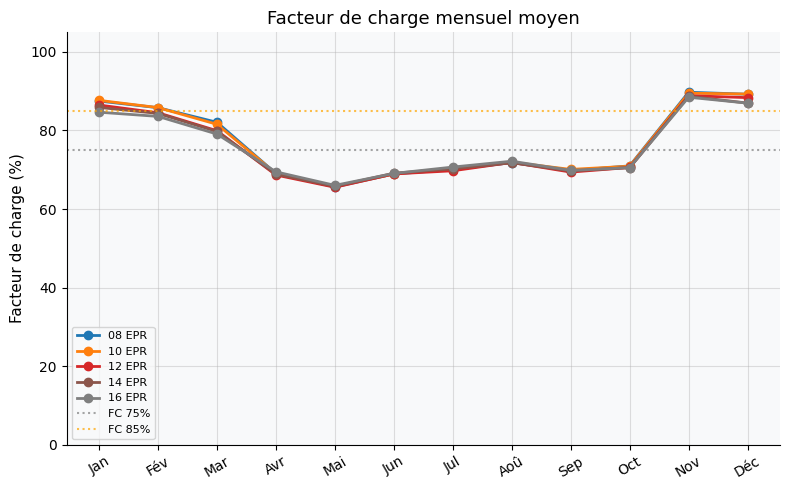

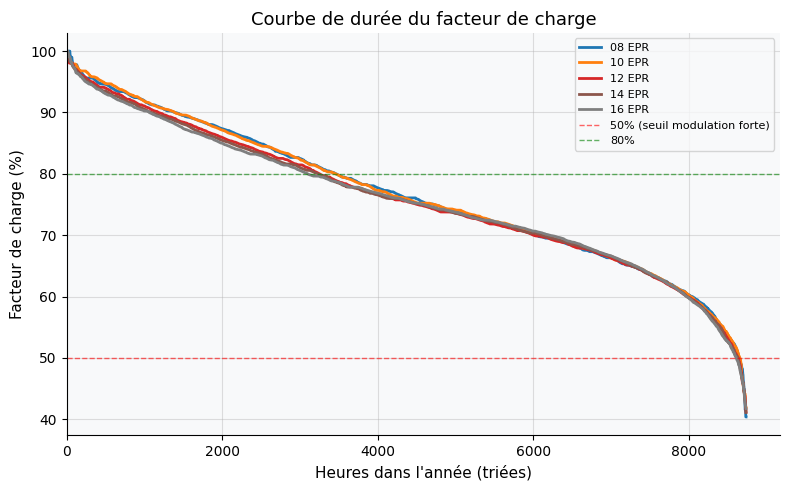

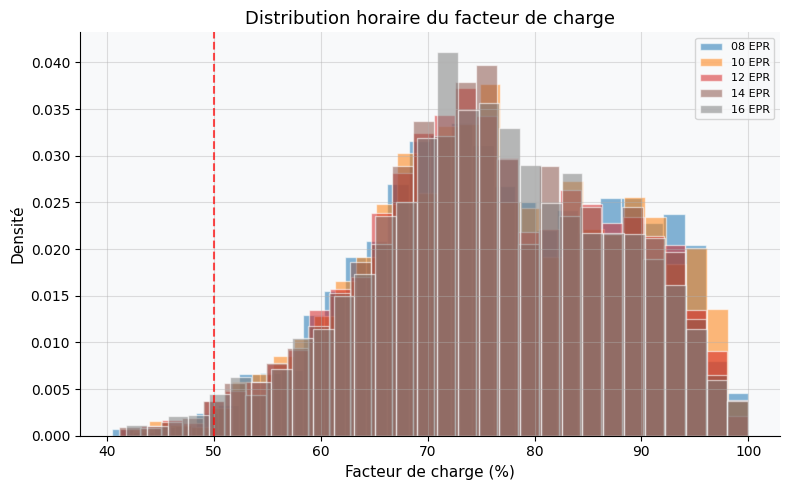

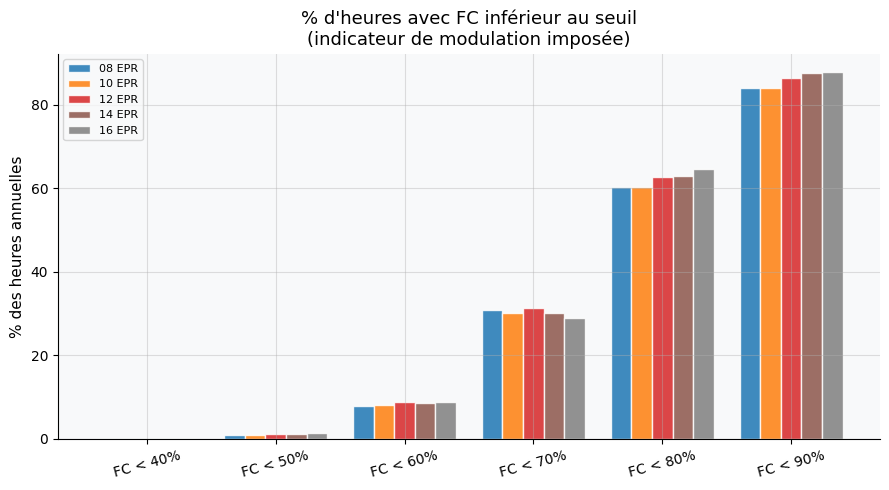

In [45]:
# ...existing code...
nuc_col = "('NUCLEAR', 'MWh', 'EXP')"
colors_sc = plt.cm.tab10(np.linspace(0, 0.7, len(scenarios)))
mois_labels = ['Jan','Fév','Mar','Avr','Mai','Jun','Jul','Aoû','Sep','Oct','Nov','Déc']
x_month = np.arange(12)

# 1) FC moyen mensuel (profil saisonnier)
fig, ax = plt.subplots(figsize=(8, 5))
for i, (scenario, df_h) in enumerate(resultats_horaires.items()):
    if nuc_col not in df_h.columns:
        continue
    nuc_h = pd.to_numeric(df_h[nuc_col], errors='coerce')
    cap = nuc_h.max()
    if pd.isna(cap) or cap <= 0:
        continue
    month = pd.to_datetime(df_h['datetime']).dt.month
    fc_monthly = (nuc_h / cap * 100).groupby(month).mean().reindex(range(1, 13))
    ax.plot(x_month, fc_monthly.values, 'o-', label=scenario, color=colors_sc[i], linewidth=2, markersize=6)

ax.axhline(75, color='grey', linestyle=':', alpha=0.7, label='FC 75%')
ax.axhline(85, color='orange', linestyle=':', alpha=0.7, label='FC 85%')
ax.set_xticks(x_month)
ax.set_xticklabels(mois_labels, rotation=30)
ax.set_title('Facteur de charge mensuel moyen')
ax.set_ylabel('Facteur de charge (%)')
ax.set_ylim(0, 105)
ax.legend(fontsize=8)
plt.tight_layout()
plt.savefig('fig_fc_mensuel.png', dpi=150, bbox_inches='tight')
plt.show()

# 2) Courbe de durée du FC
fig, ax = plt.subplots(figsize=(8, 5))
for i, (scenario, df_h) in enumerate(resultats_horaires.items()):
    if nuc_col not in df_h.columns:
        continue
    nuc_h = pd.to_numeric(df_h[nuc_col], errors='coerce').dropna()
    if nuc_h.empty:
        continue
    cap = nuc_h.max()
    if pd.isna(cap) or cap <= 0:
        continue
    fc_h = (nuc_h / cap * 100).sort_values(ascending=False)
    ax.plot(np.arange(len(fc_h)), fc_h.values, label=scenario, color=colors_sc[i], linewidth=2)

ax.axhline(50, color='red', linestyle='--', alpha=0.6, linewidth=1, label='50% (seuil modulation forte)')
ax.axhline(80, color='green', linestyle='--', alpha=0.6, linewidth=1, label='80%')
ax.set_title('Courbe de durée du facteur de charge')
ax.set_xlabel("Heures dans l'année (triées)")
ax.set_ylabel('Facteur de charge (%)')
ax.set_xlim(0)
ax.legend(fontsize=8)
plt.tight_layout()
plt.savefig('fig_fc_duree.png', dpi=150, bbox_inches='tight')
plt.show()

# 3) Distribution horaire du FC
fig, ax = plt.subplots(figsize=(8, 5))
for i, (scenario, df_h) in enumerate(resultats_horaires.items()):
    if nuc_col not in df_h.columns:
        continue
    nuc_h = pd.to_numeric(df_h[nuc_col], errors='coerce').dropna()
    if nuc_h.empty:
        continue
    cap = nuc_h.max()
    if pd.isna(cap) or cap <= 0:
        continue
    fc_h = nuc_h / cap * 100
    ax.hist(fc_h, bins=30, alpha=0.55, label=scenario, color=colors_sc[i], density=True, edgecolor='white')

ax.axvline(50, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
ax.set_title('Distribution horaire du facteur de charge')
ax.set_xlabel('Facteur de charge (%)')
ax.set_ylabel('Densité')
ax.legend(fontsize=8)
plt.tight_layout()
plt.savefig('fig_fc_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

# 4) % d'heures en-dessous de seuils de FC
fig, ax = plt.subplots(figsize=(9, 5))
seuils = [40, 50, 60, 70, 80, 90]
x_pos = np.arange(len(seuils))
w = 0.8 / max(len(scenarios), 1)

for i, (scenario, df_h) in enumerate(resultats_horaires.items()):
    if nuc_col not in df_h.columns:
        continue
    nuc_h = pd.to_numeric(df_h[nuc_col], errors='coerce').dropna()
    if nuc_h.empty:
        continue
    cap = nuc_h.max()
    if pd.isna(cap) or cap <= 0:
        continue
    fc_h = nuc_h / cap * 100
    pcts = [(fc_h < s).sum() / len(fc_h) * 100 for s in seuils]
    offset = (i - len(scenarios) / 2 + 0.5) * w
    ax.bar(x_pos + offset, pcts, w, label=scenario, color=colors_sc[i], alpha=0.85, edgecolor='white')

ax.set_xticks(x_pos)
ax.set_xticklabels([f'FC < {s}%' for s in seuils], rotation=15)
ax.set_title("% d'heures avec FC inférieur au seuil\n(indicateur de modulation imposée)")
ax.set_ylabel('% des heures annuelles')
ax.legend(fontsize=8)
plt.tight_layout()
plt.savefig('fig_fc_seuils.png', dpi=150, bbox_inches='tight')
plt.show()
# ...existing code...

### 3.10 Rentabilité nucléaire — Marge de rémunération
> **Marge de rémunération** = prix marginal horaire × production nucléaire horaire (en M€)  
> Cette recette 'merchant' doit être comparée au CAPEX (600 k€/MW/an × 1650 MW × nb EPR).  
> **Attention** : plus on module le nucléaire, plus on perd des heures à prix élevé → moins bonne rentabilité.

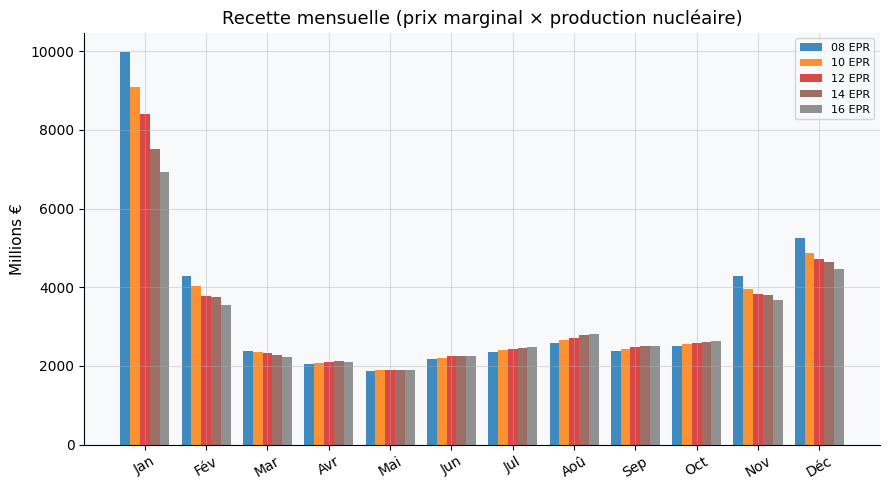

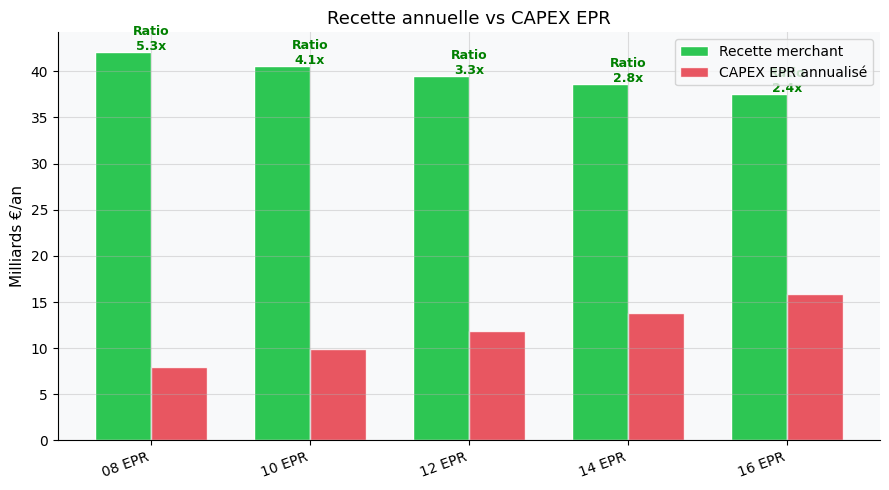

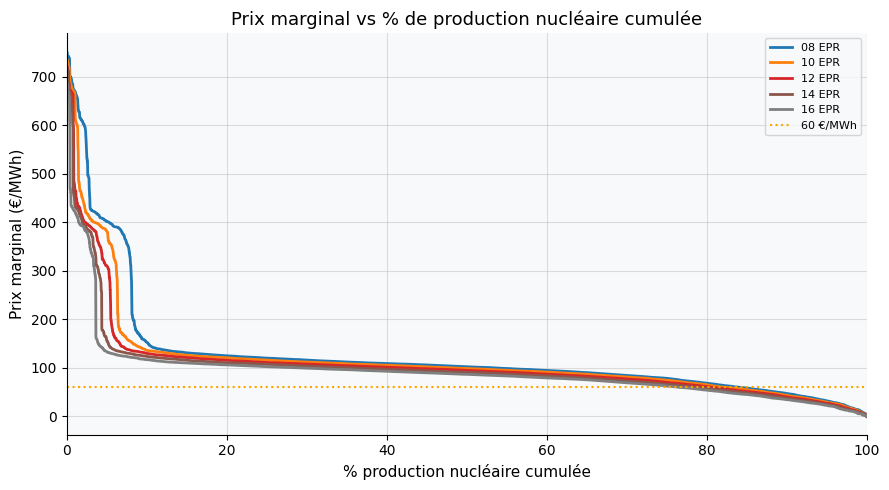

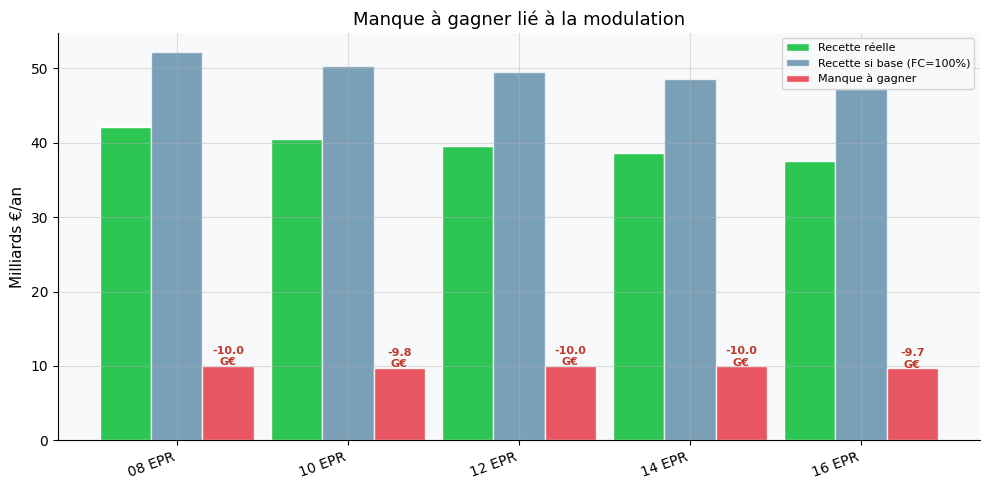


=== SYNTHÈSE RENTABILITÉ ===
Scénario                    Recette (G€)   Recette/MWh   FC moyen   Manque (G€)
--------------------------------------------------------------------------------
08 EPR                           42.12G€       124.7€/MWh     76.6%       10.02G€
10 EPR                           40.55G€       113.9€/MWh     76.7%        9.76G€
12 EPR                           39.52G€       105.6€/MWh     76.0%       10.01G€
14 EPR                           38.59G€        98.7€/MWh     75.9%        9.97G€
16 EPR                           37.53G€        91.9€/MWh     75.8%        9.71G€


In [46]:
# ...existing code...
nuc_col = "('NUCLEAR', 'MWh', 'EXP')"
mrg_col = "('MRG. PRICE', 'Euro', 'EXP')"
CAPEX_EPR_PAR_MW = 600_000   # €/MW/an
MW_PAR_EPR       = 1_650     # MW

colors_sc = plt.cm.tab10(np.linspace(0, 0.7, len(scenarios)))
mois_labels = ['Jan','Fév','Mar','Avr','Mai','Jun','Jul','Aoû','Sep','Oct','Nov','Déc']
x_month = np.arange(12)

# Pré-calculs communs
import re
nb_epr_map = {}
recettes_annuelles = {}
resultats_renta = []

for sc in scenarios:
    m = re.search(r'(\d+)', sc)
    nb_epr_map[sc] = int(m.group(1)) if m else None

for sc in scenarios:
    df_h = resultats_horaires[sc]
    if nuc_col not in df_h.columns or mrg_col not in df_h.columns:
        continue

    nuc_h  = pd.to_numeric(df_h[nuc_col], errors='coerce').fillna(0)
    prix_h = pd.to_numeric(df_h[mrg_col], errors='coerce').fillna(0)

    recettes_annuelles[sc] = (nuc_h * prix_h / 1e6).sum()  # M€
    cap = nuc_h.max()
    if pd.notna(cap) and cap > 0:
        recette_reelle = (nuc_h * prix_h).sum() / 1e9
        recette_base   = (cap * prix_h).sum() / 1e9
        perte          = recette_base - recette_reelle
        fc_moyen       = nuc_h.mean() / cap * 100
        resultats_renta.append({
            'scenario': sc, 'reelle': recette_reelle, 'base': recette_base,
            'perte': perte, 'fc': fc_moyen
        })

df_renta = pd.DataFrame(resultats_renta).set_index('scenario') if resultats_renta else pd.DataFrame()

# 1) Recette mensuelle (M€)
fig, ax = plt.subplots(figsize=(9, 5))
w = 0.8 / max(len(scenarios), 1)

for i, (scenario, df_h) in enumerate(resultats_horaires.items()):
    if nuc_col not in df_h.columns or mrg_col not in df_h.columns:
        continue
    nuc_h  = pd.to_numeric(df_h[nuc_col], errors='coerce').fillna(0)
    prix_h = pd.to_numeric(df_h[mrg_col], errors='coerce').fillna(0)
    marge_h = nuc_h * prix_h / 1e6
    month = pd.to_datetime(df_h['datetime']).dt.month
    marge_monthly = marge_h.groupby(month).sum().reindex(range(1, 13), fill_value=0)
    offset = (i - len(scenarios) / 2 + 0.5) * w
    ax.bar(x_month + offset, marge_monthly.values, width=w, label=scenario, color=colors_sc[i], alpha=0.85)

ax.set_xticks(x_month)
ax.set_xticklabels(mois_labels, rotation=30)
ax.set_title('Recette mensuelle (prix marginal × production nucléaire)')
ax.set_ylabel('Millions €')
ax.legend(fontsize=8)
plt.tight_layout()
plt.savefig('fig_renta_mensuelle.png', dpi=150, bbox_inches='tight')
plt.show()

# 2) Recette annuelle vs CAPEX EPR
fig, ax = plt.subplots(figsize=(9, 5))
x = np.arange(len(scenarios))
recettes_vals = [recettes_annuelles.get(sc, 0) / 1e3 for sc in scenarios]  # M€ -> G€
capex_vals = [((nb_epr_map.get(sc) or 0) * MW_PAR_EPR * CAPEX_EPR_PAR_MW / 1e9) for sc in scenarios]
w = 0.35

ax.bar(x - w/2, recettes_vals, w, label='Recette merchant', color='#2DC653', edgecolor='white')
ax.bar(x + w/2, capex_vals,   w, label='CAPEX EPR annualisé', color='#E63946', edgecolor='white', alpha=0.85)

for i, (r, c) in enumerate(zip(recettes_vals, capex_vals)):
    if c > 0:
        ax.text(i, max(r, c) + 0.2, f'Ratio\n{r/c:.1f}x',
                ha='center', fontsize=9, fontweight='bold',
                color='green' if r/c > 1 else 'red')

ax.set_xticks(x)
ax.set_xticklabels(scenarios, rotation=20, ha='right')
ax.set_title('Recette annuelle vs CAPEX EPR')
ax.set_ylabel('Milliards €/an')
ax.legend()
plt.tight_layout()
plt.savefig('fig_renta_vs_capex.png', dpi=150, bbox_inches='tight')
plt.show()

# 3) Prix marginal vs % production nucléaire cumulée
fig, ax = plt.subplots(figsize=(9, 5))
for i, (scenario, df_h) in enumerate(resultats_horaires.items()):
    if nuc_col not in df_h.columns or mrg_col not in df_h.columns:
        continue
    nuc_h  = pd.to_numeric(df_h[nuc_col], errors='coerce').fillna(0)
    prix_h = pd.to_numeric(df_h[mrg_col], errors='coerce').fillna(0)

    df_tmp = pd.DataFrame({'prix': prix_h.values, 'nuc': nuc_h.values})
    df_tmp = df_tmp[df_tmp['nuc'] > 0].sort_values('prix', ascending=False).reset_index(drop=True)
    if df_tmp.empty or df_tmp['nuc'].sum() <= 0:
        continue

    nuc_cum = df_tmp['nuc'].cumsum() / df_tmp['nuc'].sum() * 100
    ax.plot(nuc_cum.values, df_tmp['prix'].values, label=scenario, color=colors_sc[i], linewidth=2)

ax.axhline(60, color='orange', linestyle=':', linewidth=1.5, label='60 €/MWh')
ax.set_title('Prix marginal vs % de production nucléaire cumulée')
ax.set_xlabel('% production nucléaire cumulée')
ax.set_ylabel('Prix marginal (€/MWh)')
ax.set_xlim(0, 100)
ax.legend(fontsize=8)
plt.tight_layout()
plt.savefig('fig_renta_prix_cumule.png', dpi=150, bbox_inches='tight')
plt.show()

# 4) Manque à gagner lié à la modulation
if not df_renta.empty:
    fig, ax = plt.subplots(figsize=(10, 5))
    x = np.arange(len(df_renta))
    w = 0.3

    ax.bar(x - w, df_renta['reelle'], w, label='Recette réelle', color='#2DC653', edgecolor='white')
    ax.bar(x,     df_renta['base'],   w, label='Recette si base (FC=100%)', color='#457B9D', edgecolor='white', alpha=0.7)
    ax.bar(x + w, df_renta['perte'],  w, label='Manque à gagner', color='#E63946', edgecolor='white', alpha=0.85)

    for j, (_, row) in enumerate(df_renta.iterrows()):
        ax.text(j + w, row['perte'] + 0.08, f"-{row['perte']:.1f}\nG€",
                ha='center', fontsize=8, fontweight='bold', color='#C0392B')

    ax.set_xticks(x)
    ax.set_xticklabels(df_renta.index, rotation=20, ha='right')
    ax.set_title('Manque à gagner lié à la modulation')
    ax.set_ylabel('Milliards €/an')
    ax.legend(fontsize=8)
    plt.tight_layout()
    plt.savefig('fig_renta_perte_modulation.png', dpi=150, bbox_inches='tight')
    plt.show()

# Synthèse texte
print('\n=== SYNTHÈSE RENTABILITÉ ===')
print(f'{"Scénario":<25} {"Recette (G€)":>14} {"Recette/MWh":>13} {"FC moyen":>10} {"Manque (G€)":>13}')
print('-' * 80)

if not df_renta.empty:
    for _, row in df_renta.iterrows():
        df_h = resultats_horaires[row.name]
        nuc_h  = pd.to_numeric(df_h[nuc_col], errors='coerce').fillna(0)
        prix_h = pd.to_numeric(df_h[mrg_col], errors='coerce').fillna(0)
        rec_mwh = (nuc_h * prix_h).sum() / nuc_h.sum() if nuc_h.sum() > 0 else 0
        print(f'{row.name:<25} {row["reelle"]:>12.2f}G€ {rec_mwh:>11.1f}€/MWh {row["fc"]:>8.1f}% {row["perte"]:>11.2f}G€')
# ...existing code...

### 3.11 Mix électrique France — Camembert par filière
> La **balance export** est indiquée séparément (production - consommation).  
> Pour la répartition des exports **par pays voisin** (ES, DE, GB, BE, CH, IT), il faut charger
> les fichiers de liens Antares (voir cellule suivante).

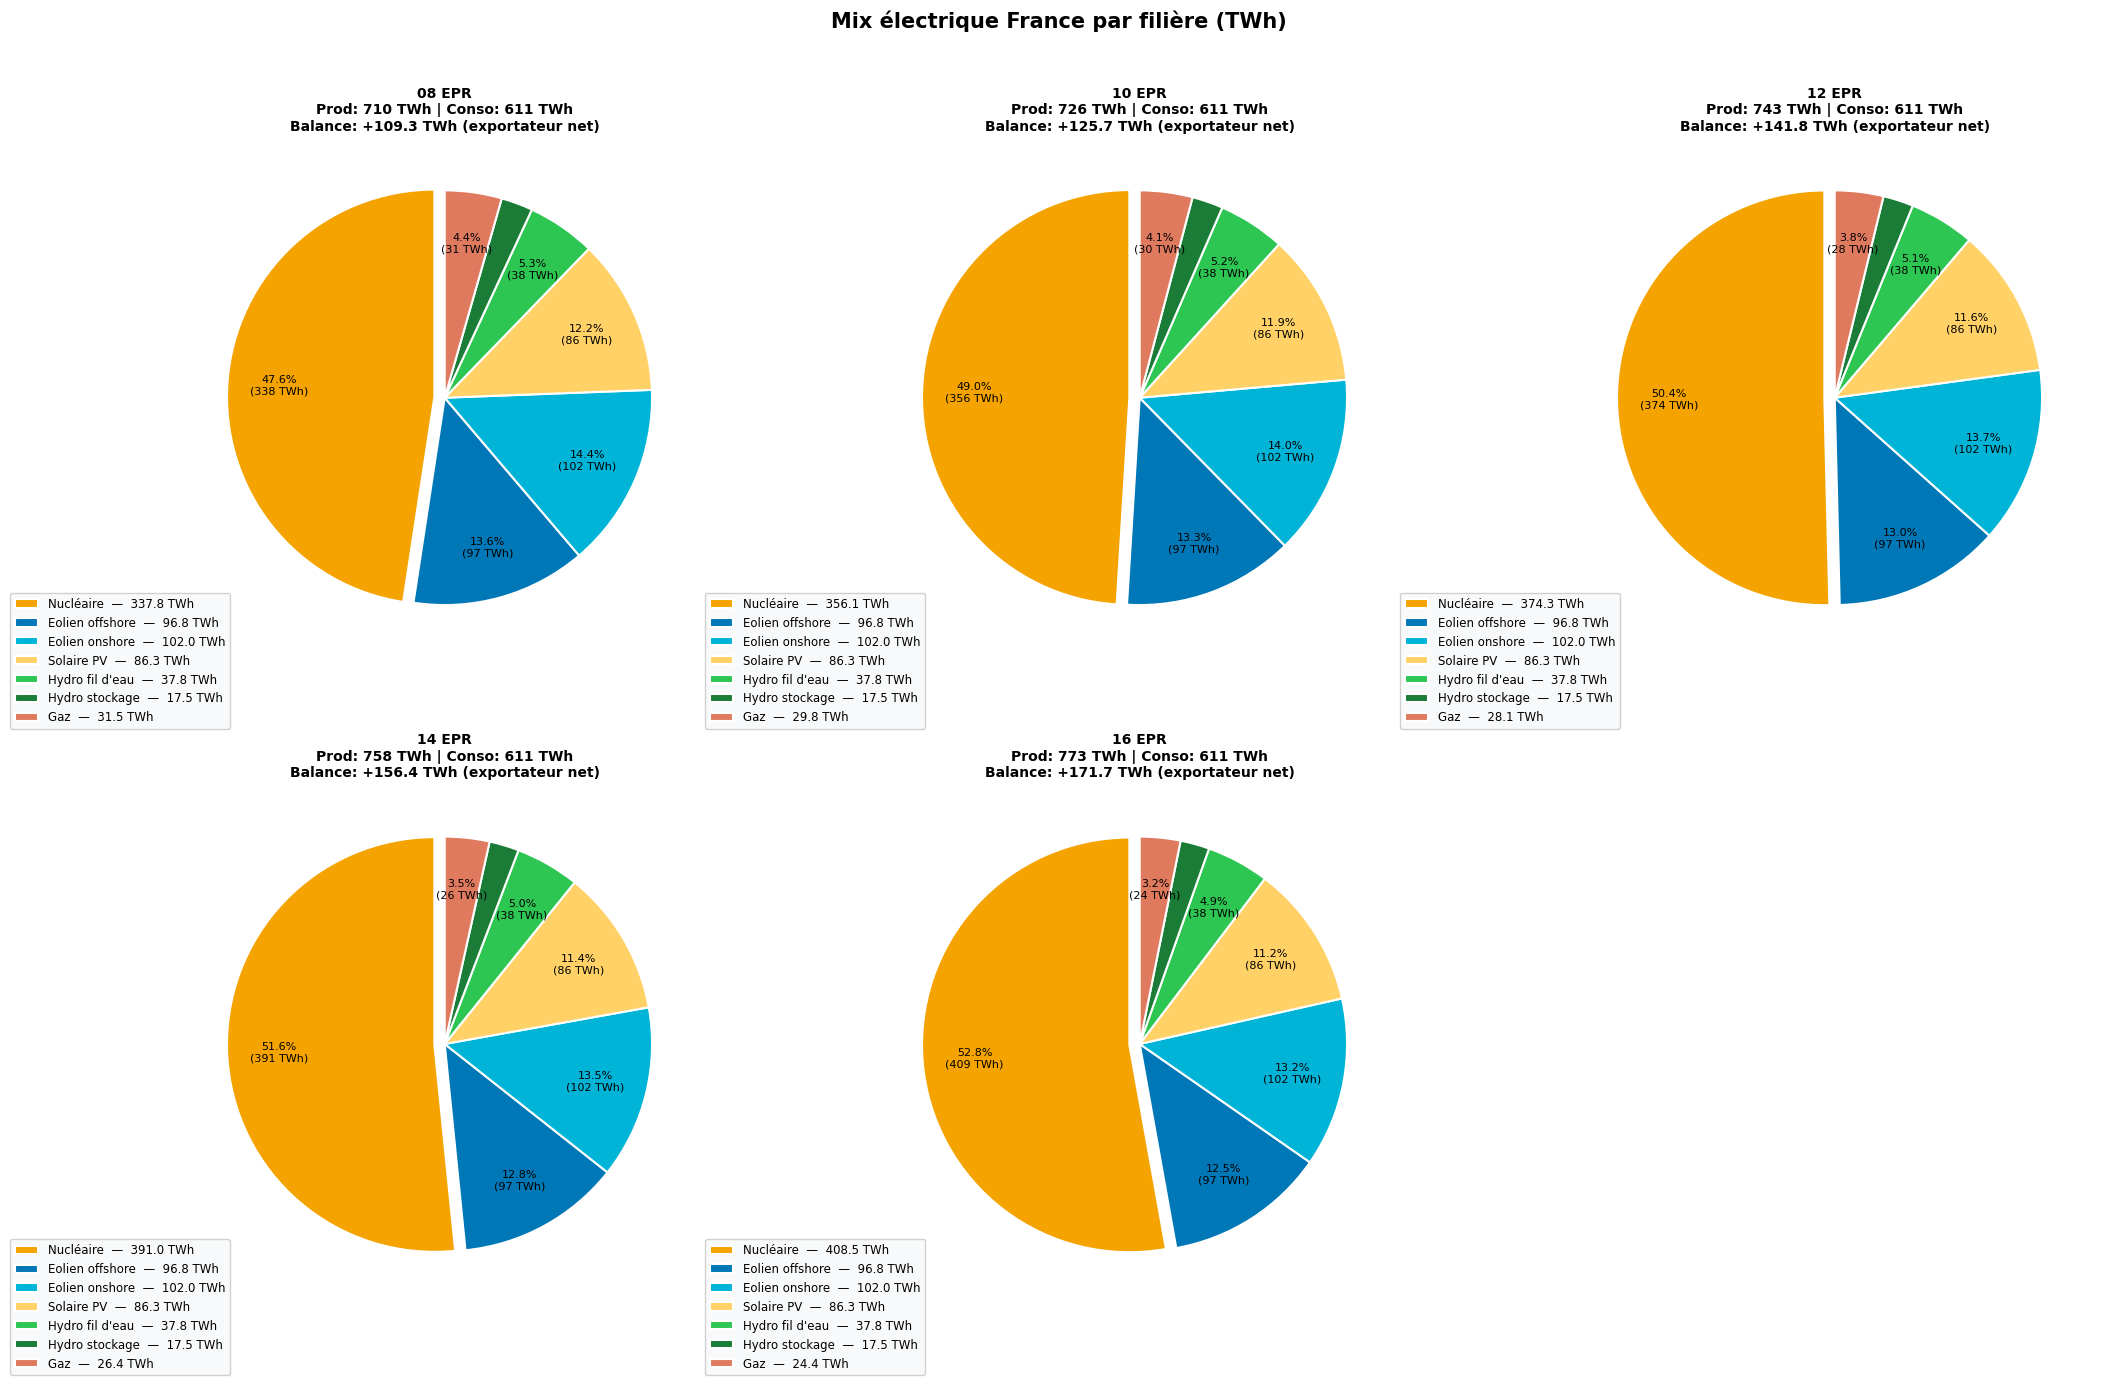

In [26]:
# Couleurs et sources du mix France
MIX_SOURCES = {
    'Nucléaire':        ("('NUCLEAR', 'MWh', 'EXP')",       '#F4A300'),
    'Eolien offshore':  ("('WIND OFFSHORE', 'MWh', 'EXP')", '#0077B6'),
    'Eolien onshore':   ("('WIND ONSHORE', 'MWh', 'EXP')",  '#00B4D8'),
    'Solaire PV':       ("('SOLAR PV', 'MWh', 'EXP')",      '#FFD166'),
    'Solaire toiture':  ("('SOLAR ROOFT', 'MWh', 'EXP')",   '#FFC300'),
    'Hydro fil d\'eau': ("('H. ROR', 'MWh', 'EXP')",        '#2DC653'),
    'Hydro stockage':   ("('H. STOR', 'MWh', 'EXP')",       '#1A7C36'),
    'Gaz':              ("('GAS', 'MWh', 'EXP')",            '#E07A5F'),
    'Fioul':            ("('OIL', 'MWh', 'EXP')",            '#6D6875'),
}

n_sc = len(scenarios)
ncols = min(3, n_sc)
nrows = (n_sc + ncols - 1) // ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(7 * ncols, 7 * nrows))
if n_sc == 1:
    axes = [[axes]]
elif nrows == 1:
    axes = [axes]
fig.suptitle('Mix électrique France par filière (TWh)', fontsize=15, fontweight='bold')

for idx, scenario in enumerate(scenarios):
    ax = axes[idx // ncols][idx % ncols]
    df_h = resultats_horaires[scenario]

    labels_pie, vals_pie, colors_pie = [], [], []
    for label, (col, color) in MIX_SOURCES.items():
        if col in df_h.columns:
            v = pd.to_numeric(df_h[col], errors='coerce').sum() / 1e6
            if v > 0.5:  # ignorer < 0.5 TWh
                labels_pie.append(label)
                vals_pie.append(v)
                colors_pie.append(color)

    prod_totale = sum(vals_pie)
    load_col = "('LOAD', 'MWh', 'EXP')"
    balance_col = "('BALANCE', 'MWh', 'EXP')"
    conso = pd.to_numeric(df_h[load_col], errors='coerce').sum() / 1e6 if load_col in df_h.columns else 0
    balance = pd.to_numeric(df_h[balance_col], errors='coerce').sum() / 1e6 if balance_col in df_h.columns else 0

    # Explode le nucléaire pour le mettre en valeur
    explode = [0.05 if 'Nucl' in l else 0 for l in labels_pie]

    wedges, texts, autotexts = ax.pie(
        vals_pie, labels=None, colors=colors_pie,
        autopct=lambda p: f'{p:.1f}%\n({p*prod_totale/100:.0f} TWh)' if p > 3 else '',
        startangle=90, explode=explode,
        wedgeprops={'edgecolor': 'white', 'linewidth': 1.5},
        pctdistance=0.75
    )
    for t in autotexts:
        t.set_fontsize(8)

    # Légende avec TWh
    legend_labels = [f'{l}  —  {v:.1f} TWh' for l, v in zip(labels_pie, vals_pie)]
    ax.legend(wedges, legend_labels, loc='lower left', bbox_to_anchor=(-0.35, -0.15),
              fontsize=8.5, framealpha=0.9)

    signe = '+' if balance >= 0 else ''
    direction = 'exportateur net' if balance >= 0 else 'importateur net'
    ax.set_title(
        f'{scenario}\n'
        f'Prod: {prod_totale:.0f} TWh | Conso: {conso:.0f} TWh\n'
        f'Balance: {signe}{balance:.1f} TWh ({direction})',
        fontsize=10, fontweight='bold'
    )

# Masquer les axes vides
for idx in range(n_sc, nrows * ncols):
    axes[idx // ncols][idx % ncols].set_visible(False)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('fig_camembert_mix.png', dpi=150, bbox_inches='tight')
plt.show()

### 3.12 Exports France par pays voisin
> Cette cellule nécessite les **fichiers de liens Antares** (ex: `values-hourly.txt` dans le dossier
> `output/.../links/fr - es/`).  
> Renseigner le dictionnaire `FICHIERS_LIENS` ci-dessous avec les chemins vers ces fichiers,
> ou exporter depuis Antares les résultats de liens au format CSV/Excel.

In [27]:
# ============================================================
# CONFIGURATION — renseigner les chemins vers les fichiers de liens Antares
# Chaque fichier doit contenir une colonne 'FLOW LIN.' ou similaire
# Flux positif = export FR -> pays, flux négatif = import
# ============================================================
FICHIERS_LIENS = {
    # Exemple (décommenter et adapter):
    # '14 EPR': {
    #     'Espagne (ES)':     'chemin/vers/fr-es_14epr.csv',
    #     'Allemagne (DE)':   'chemin/vers/fr-de_14epr.csv',
    #     'Grande-Bretagne':  'chemin/vers/fr-gb_14epr.csv',
    #     'Belgique (BE)':    'chemin/vers/fr-be_14epr.csv',
    #     'Suisse (CH)':      'chemin/vers/fr-ch_14epr.csv',
    #     'Italie (IT)':      'chemin/vers/fr-it_14epr.csv',
    # },
}

if not FICHIERS_LIENS:
    print('⚠️  Aucun fichier de liens configuré.')
    print('   Pour obtenir les exports par pays :')
    print('   1. Dans Antares : Output → [votre simulation] → Links → fr - XX → values-hourly')
    print('   2. Exporter en CSV')
    print('   3. Renseigner le dict FICHIERS_LIENS ci-dessus')
    print()
    print('   En attendant, voici la balance totale par scénario :')
    print(f'   {"Scénario":<25} {"Balance nette":>15}')
    print('   ' + '-' * 42)
    for sc in scenarios:
        df_h = resultats_horaires[sc]
        bal_col = "('BALANCE', 'MWh', 'EXP')"
        if bal_col in df_h.columns:
            bal = pd.to_numeric(df_h[bal_col], errors='coerce').sum() / 1e6
            signe = '+' if bal >= 0 else ''
            print(f'   {sc:<25} {signe}{bal:>12.1f} TWh')
else:
    # --- Traitement si les fichiers sont fournis ---
    all_pays = sorted(set(p for liens in FICHIERS_LIENS.values() for p in liens))
    n_sc = len(FICHIERS_LIENS)
    fig, axes = plt.subplots(1, n_sc, figsize=(7 * n_sc, 6))
    if n_sc == 1: axes = [axes]
    couleurs_pays = plt.cm.Set2(np.linspace(0, 1, len(all_pays)))
    c_map = dict(zip(all_pays, couleurs_pays))

    for idx, (scenario, liens) in enumerate(FICHIERS_LIENS.items()):
        ax = axes[idx]
        exports, imports_ = {}, {}
        for pays, filepath in liens.items():
            df_link = pd.read_csv(filepath, sep=None, engine='python')
            flow_col = [c for c in df_link.columns if 'FLOW' in c.upper() or 'flow' in c.lower()][0]
            flux = pd.to_numeric(df_link[flow_col], errors='coerce')
            exp_twh = flux[flux > 0].sum() / 1e6
            imp_twh = flux[flux < 0].sum() / 1e6
            exports[pays]  = exp_twh
            imports_[pays] = abs(imp_twh)

        # Camembert exports
        exp_vals   = [v for v in exports.values() if v > 0]
        exp_labels = [k for k, v in exports.items() if v > 0]
        exp_colors = [c_map[k] for k in exp_labels]
        if exp_vals:
            ax.pie(exp_vals, labels=exp_labels, colors=exp_colors,
                   autopct='%1.1f%%', startangle=90,
                   wedgeprops={'edgecolor': 'white', 'linewidth': 1.5})
            ax.set_title(f'{scenario}\nExports bruts par pays ({sum(exp_vals):.1f} TWh)')

    plt.tight_layout()
    plt.savefig('fig_exports_pays.png', dpi=150, bbox_inches='tight')
    plt.show()

⚠️  Aucun fichier de liens configuré.
   Pour obtenir les exports par pays :
   1. Dans Antares : Output → [votre simulation] → Links → fr - XX → values-hourly
   2. Exporter en CSV
   3. Renseigner le dict FICHIERS_LIENS ci-dessus

   En attendant, voici la balance totale par scénario :
   Scénario                    Balance nette
   ------------------------------------------
   08 EPR                    +       109.3 TWh
   10 EPR                    +       125.7 TWh
   12 EPR                    +       141.8 TWh
   14 EPR                    +       156.4 TWh
   16 EPR                    +       171.7 TWh


## 💾 4. Export Excel de synthèse

In [28]:
output_path = Path(DOSSIER_EXCEL) / 'comparaison_scenarios_EPR.xlsx'

with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
    # Valeurs absolues (toutes les colonnes)
    df_res.T.to_excel(writer, sheet_name='Valeurs absolues')
    
    # Deltas % vs référence
    ref = df_res.index[0]
    df_delta = df_res.copy()
    for col in df_res.columns:
        ref_val = df_res.loc[ref, col]
        if pd.notna(ref_val) and ref_val != 0:
            df_delta[col] = ((df_res[col] - ref_val) / abs(ref_val) * 100).round(2)
    df_delta.T.to_excel(writer, sheet_name=f'Delta % vs {ref[:20]}')
    
    # Synthèse indicateurs clés
    cols_cles = [c for c in [
        "LOLD [h/an]", "Energie non servie [MWh]", "Spillage EnR [MWh]",
        "Emissions CO2 [T]", "Intensité CO2 [gCO2/kWh]", "OPEX [€]",
        "Prix marginal moyen [€/MWh]", "Balance nette (export+) [MWh]",
        "Production nucléaire [MWh]", "Production gaz [MWh]",
        "Part nucléaire [%]", "Part fossile [%]"
    ] if c in df_res.columns]
    df_res[cols_cles].T.to_excel(writer, sheet_name='Synthèse clés')

print(f'✅ Fichier exporté : {output_path.resolve()}')

✅ Fichier exporté : /mnt/c/Users/fbazon/TP/antares/comparaison_scenarios_EPR.xlsx
